<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

**Alumno:**

**Nahuel Otonelo Canale**

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import random
import io
import pickle

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy









# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs


# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


# Lo usaré para levantar el modelo ya entreando (en caso de que exista)
import os




In [9]:


# Verificar disponibilidad de CUDA
if torch.cuda.is_available():
    print("✅ ¡ÉXITO! PyTorch detectó tu GPU.")
    print(f"Modelo de GPU: {torch.cuda.get_device_name(0)}")
    print(f"Versión de CUDA: {torch.version.cuda}")
else:
    print("⚠️ PyTorch NO detectó la GPU. Se usará el procesador (CPU).")

✅ ¡ÉXITO! PyTorch detectó tu GPU.
Modelo de GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Versión de CUDA: 12.8


### Datos
Utilizaremos como dataset el libro de Robinson Crusoe, de Daniel Defoe.

In [10]:
raw_html = urllib.request.urlopen('https://www.textos.info/daniel-defoe/robinson-crusoe/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [11]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' nací en 1632,\nen la ciudad de york, de una buena familia, aunque no de la región,\npues mi padre era un extranjero de brema que, inicialmente, se\nasentó en hull. allí consiguió hacerse con una considerable fortuna\ncomo comerciante y, más tarde, abandonó sus negocios y se fue a\nvivir a york, donde se casó con mi madre, que pertenecía a la\nfamilia robinson, una de las buenas familias del condado de la cual\nobtuve mi nombre, robinson kreutznaer. mas, por la habitual\nalteración de las palabras que se hace en inglaterra, ahora nos\nllaman y nosotros también nos llamamos y escribimos nuestro nombre\ncrusoe; y así me han llamado siempre mis compañeros. tenía dos hermanos mayores, uno de ellos fue coronel de un\nregimiento de infantería inglesa en flandes, que antes había estado\nbajo el mando del célebre coronel lockhart, y murió en la batalla\nde dunkerque contra los españoles. lo que fue de mi segundo\nhermano, nunca lo he sabido al igual que mi padre y mi madre\ntampoco supieron l

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [12]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

print(" la longitud de vocabulario de caracteres es: ", len(chars_vocab))


# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

 la longitud de vocabulario de caracteres es:  65


###  Tokenizar

In [13]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]
print(tokenized_text[:1000])  

[11, 58, 32, 38, 9, 11, 28, 58, 11, 19, 17, 43, 25, 1, 18, 28, 58, 11, 2, 32, 11, 38, 16, 63, 39, 32, 39, 11, 39, 28, 11, 55, 13, 36, 33, 1, 11, 39, 28, 11, 63, 58, 32, 11, 8, 63, 28, 58, 32, 11, 31, 32, 10, 16, 2, 16, 32, 1, 11, 32, 63, 58, 40, 63, 28, 11, 58, 13, 11, 39, 28, 11, 2, 32, 11, 36, 28, 37, 16, 52, 58, 1, 18, 48, 63, 28, 34, 11, 10, 16, 11, 48, 32, 39, 36, 28, 11, 28, 36, 32, 11, 63, 58, 11, 28, 35, 5, 36, 32, 58, 51, 28, 36, 13, 11, 39, 28, 11, 8, 36, 28, 10, 32, 11, 40, 63, 28, 1, 11, 16, 58, 16, 38, 16, 32, 2, 10, 28, 58, 5, 28, 1, 11, 34, 28, 18, 32, 34, 28, 58, 5, 52, 11, 28, 58, 11, 29, 63, 2, 2, 6, 11, 32, 2, 2, 9, 11, 38, 13, 58, 34, 16, 37, 63, 16, 52, 11, 29, 32, 38, 28, 36, 34, 28, 11, 38, 13, 58, 11, 63, 58, 32, 11, 38, 13, 58, 34, 16, 39, 28, 36, 32, 8, 2, 28, 11, 31, 13, 36, 5, 63, 58, 32, 18, 38, 13, 10, 13, 11, 38, 13, 10, 28, 36, 38, 16, 32, 58, 5, 28, 11, 55, 1, 11, 10, 14, 34, 11, 5, 32, 36, 39, 28, 1, 11, 32, 8, 32, 58, 39, 13, 58, 52, 11, 34, 63, 34, 1

### Organizando y estructurando el dataset

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [15]:
print(X.shape)      
print(X[0,:10])
print(y[0,:10])
vocab_size = len(chars_vocab)
print(vocab_size)


(495718, 100)
[11 58 32 38  9 11 28 58 11 19]
[58 32 38  9 11 28 58 11 19 17]
65


# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.rnn(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)


model = RNNModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

print(model)

RNNModel(
  (rnn): RNN(65, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=65, bias=True)
)



### Definir el modelo

### Entrenamiento

In [26]:
# Entrena el modelo, lo guarda y guarda el historial, luego cuando lo corres de nuevo, verifica si el modelo esta entrenado


device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
batch_size = 256
num_epochs = 20
patience = 5


train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long),
                                               torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def prepare_val_data(val_data, max_context_size, vocab_size):
    targets, padded = [], []
    info = []
    count = 0

    for seq in val_data:
        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1, len_seq)]
        targets.extend([seq[i] for i in range(1, len_seq)])

        if len(subseq) != 0:
            arr = np.zeros((len(subseq), max_context_size), dtype=np.int64)
            for j, s in enumerate(subseq):
                # truncar si es más larga
                s = s[-max_context_size:]
                arr[j, -len(s):] = s
            padded.append(arr)
            info.append((count, count + len_seq))
            count += len_seq

    padded = np.vstack(padded)
    return torch.tensor(padded, dtype=torch.long), torch.tensor(targets, dtype=torch.long), info


def compute_perplexity(model, val_inputs, val_targets, batch_size=256):
    model.eval()
    all_log_probs = []
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)

            logits = model(xb.unsqueeze(-1))
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())

    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

history_ppl = []
min_score = float("inf")
patience_counter = 0

# preparar datos de validación
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val,
                                                     max_context_size=max_context_size,
                                                     vocab_size=vocab_size)

if os.path.exists(RNN_CHECKPOINT_FILENAME):
    # Cargar checkpoint completo
    checkpoint = torch.load(RNN_CHECKPOINT_FILENAME, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    history_ppl = checkpoint['history_ppl']
    print(f"Modelo e historial cargados desde {RNN_CHECKPOINT_FILENAME}")
else:
    print("No se encontró checkpoint. Iniciando entrenamiento...")
    # --- training loop ---
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb.unsqueeze(-1))
            loss = criterion(logits.transpose(1, 2), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        current_ppl = compute_perplexity(model, val_inputs, val_targets, batch_size=batch_size)
        history_ppl.append(current_ppl)

        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

        # early stopping
        if current_ppl < min_score:
            min_score = current_ppl
            torch.save({
                'model_state_dict': model.state_dict(),
                'history_ppl': history_ppl
            }, RNN_CHECKPOINT_FILENAME)
            print("Saved new best model checkpoint!")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

No se encontró checkpoint. Iniciando entrenamiento...
Epoch 1/20 - loss: 1.1988 - val_ppl: 5.0751
Saved new best model checkpoint!
Epoch 2/20 - loss: 1.1915 - val_ppl: 5.0591
Saved new best model checkpoint!
Epoch 3/20 - loss: 1.1880 - val_ppl: 5.0633
Epoch 4/20 - loss: 1.1852 - val_ppl: 5.1018
Epoch 5/20 - loss: 1.1826 - val_ppl: 5.0869
Epoch 6/20 - loss: 1.1805 - val_ppl: 5.1228
Epoch 7/20 - loss: 1.1786 - val_ppl: 5.1284
Early stopping triggered


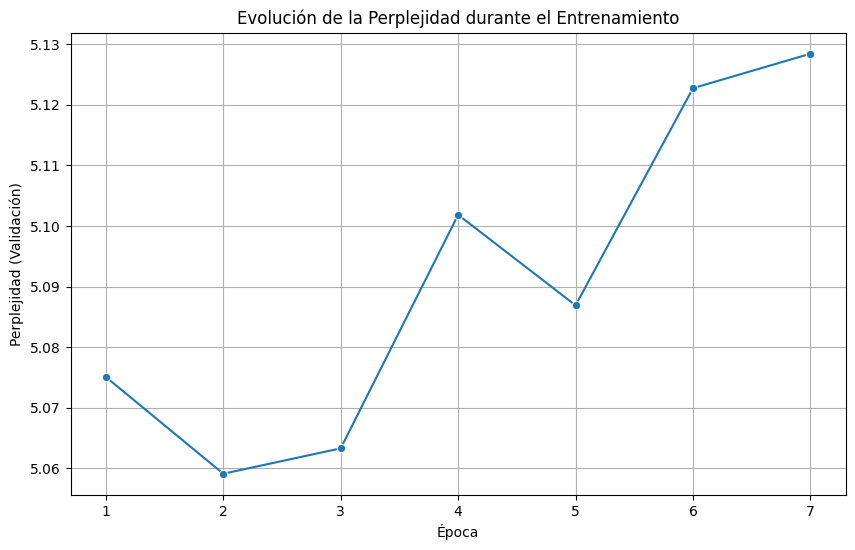

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)

plt.figure(figsize=(10, 6))
sns.lineplot(x=epoch_count, y=history_ppl, marker='o')

plt.title("Evolución de la Perplejidad durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Perplejidad (Validación)")
plt.grid(True)
plt.show()


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

# !pip install -q gradio

In [29]:
import gradio as gr

def model_response(human_text):
    model.eval()  # modo evaluación

    # encodeamos
    encoded = [char2idx.get(ch, 0) for ch in human_text.lower()]  # si el char no está, 0
    if len(encoded) > max_context_size:
        encoded = encoded[-max_context_size:]  # truncar
    else:
        encoded = [0]*(max_context_size - len(encoded)) + encoded  # pad izquierda

    # tensor al device correcto
    x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)
    # shape: (1, seq_len=max_context_size, 1)

    # forward
    with torch.no_grad():
        logits = model(x)              # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1)  # último timestep

    y_hat = torch.argmax(probs).item()
    out_word = idx2char[y_hat]

    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [30]:
def generate_seq(model, seed_text, max_length, n_words):
    model.eval()
    device = next(model.parameters()).device  # detecta si está en cpu o cuda
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()]  # si no está → 0

        # truncar o padear a max_length
        if len(encoded) > max_length:
            encoded = encoded[-max_length:]
        else:
            encoded = [0] * (max_length - len(encoded)) + encoded

        # convertir a tensor (batch=1, seq_len=max_length, 1)
        x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

        # --- Forward ---
        with torch.no_grad():
            logits = model(x)  # (1, seq_len, vocab_size)
            probs = F.softmax(logits[0, -1, :], dim=-1)
            y_hat = torch.argmax(probs).item()

        # convertir a caracter
        out_char = idx2char[y_hat]
        output_text += out_char

    return output_text

In [31]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez la parte de la costa de esta '

###  Beam search y muestreo aleatorio

In [32]:


def encode(text, max_length=max_context_size, device=None):
    # convertir cada caracter a índice (si no está en vocabulario, usar 0)
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]

    # truncar o padear
    if len(encoded) > max_length:
        encoded = encoded[-max_length:]
    else:
        encoded = [0] * (max_length - len(encoded)) + encoded

    # convertir a tensor (batch=1, seq_len, 1)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1)

    if device is not None:
        tensor = tensor.to(device)
    return tensor


def decode(seq):
    if torch.is_tensor(seq):
        seq = seq.cpu().numpy().tolist()
    return ''.join([idx2char[ch] for ch in seq])

In [33]:


# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # sumamos los log probs acumulados
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode: {mode}. Use 'det' or 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input_text, max_length,temp=1.0, mode='det'):
    model.eval()
    device = next(model.parameters()).device

    encoded = encode(input_text, max_length=max_length, device=device)  # (1, seq_len, 1)

    with torch.no_grad():
        logits = model(encoded)  # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

    vocab_size = probs.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded.squeeze(-1).cpu().numpy()[0]] * num_beams  # shape: (seq_len,)

    # seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([probs],
                                                      num_beams,
                                                      vocab_size,
                                                      history_probs,
                                                      history_tokens,
                                                      temp,
                                                      mode)

    #loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            # mantener contexto de tamaño max_length
            input_update = hist[-max_length:]
            x = torch.tensor(input_update, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

            with torch.no_grad():
                logits = model(x)
                y_hat = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                          num_beams,
                                                          vocab_size,
                                                          history_probs,
                                                          history_tokens,
                                                          temp,
                                                          mode)

    # devolver secuencias generadas (últimos tokens relevantes)
    return history_tokens[:, -(len(input_text) + num_words):]


In [34]:
max_context_size

100

In [38]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=200,input_text="viernes",max_length=max_context_size,temp=1,mode="sto")

In [39]:
# veamos las salidas
decode(salidas[0])

'viernes con ellos y la estación de lluvia, para esta condición a pensar en la orilla. no obstante, como había construido en la orilla en la que habían estado en el que había convertido en la orilla estaba en'

Viernes es un personaje de la historia. El texto tiene algo de sentido.


In [44]:


# --- Definición de Modelos con Dropout ---

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, dropout_prob=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # <--- Capa de Dropout
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = x.squeeze(-1).long()
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.rnn(x)
        out = self.dropout(out)  # <--- Aplicamos Dropout aquí
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, dropout_prob=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # <--- Capa de Dropout
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = x.squeeze(-1).long()
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.lstm(x)
        out = self.dropout(out)  # <--- Aplicamos Dropout aquí
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, dropout_prob=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.gru = nn.GRU(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # <--- Capa de Dropout
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = x.squeeze(-1).long()
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.gru(x)
        out = self.dropout(out)  # <--- Aplicamos Dropout aquí
        out = self.fc(out)
        return out

# --- Función de Entrenamiento Reutilizable ---

def train_and_evaluate(model_class, model_name, train_loader, val_inputs, val_targets, vocab_size, device, num_epochs=20, patience=5):
    print(f"\n{'='*20} Entrenando/Cargando {model_name} {'='*20}")
    
    filename = f"{model_name}_checkpoint.pt"
    model = model_class(vocab_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    
    history_ppl = []
    min_score = float("inf")
    patience_counter = 0
    
    # Intentar cargar checkpoint
    if os.path.exists(filename):
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        history_ppl = checkpoint['history_ppl']
        print(f"✅ Modelo cargado desde {filename}")
    else:
        print("🚀 Iniciando entrenamiento...")
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb.unsqueeze(-1))
                loss = criterion(logits.transpose(1, 2), yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            current_ppl = compute_perplexity(model, val_inputs, val_targets)
            history_ppl.append(current_ppl)

            print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

            if current_ppl < min_score:
                min_score = current_ppl
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'history_ppl': history_ppl
                }, filename)
                print("  -> Nuevo mejor modelo guardado!")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("🛑 Early stopping activado")
                    break
    
    # Graficar
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=range(1, len(history_ppl) + 1), y=history_ppl, marker='o')
    plt.title(f"Perplejidad: {model_name}")
    plt.xlabel("Época")
    plt.ylabel("PPL Validación")
    plt.grid(True)
    plt.show()
    
    return model, history_ppl


==================== Entrenando/Cargando RNN ====================
🚀 Iniciando entrenamiento...
Epoch 1/20 - loss: 1.8883 - val_ppl: 5.5584
  -> Nuevo mejor modelo guardado!
Epoch 2/20 - loss: 1.5677 - val_ppl: 5.1435
  -> Nuevo mejor modelo guardado!
Epoch 3/20 - loss: 1.4810 - val_ppl: 5.0889
  -> Nuevo mejor modelo guardado!
Epoch 4/20 - loss: 1.4379 - val_ppl: 4.9854
  -> Nuevo mejor modelo guardado!
Epoch 5/20 - loss: 1.4127 - val_ppl: 4.9838
  -> Nuevo mejor modelo guardado!
Epoch 6/20 - loss: 1.3969 - val_ppl: 5.0214
Epoch 7/20 - loss: 1.3860 - val_ppl: 4.9872
Epoch 8/20 - loss: 1.3785 - val_ppl: 4.9971
Epoch 9/20 - loss: 1.3727 - val_ppl: 5.0172
Epoch 10/20 - loss: 1.3686 - val_ppl: 5.0022
🛑 Early stopping activado


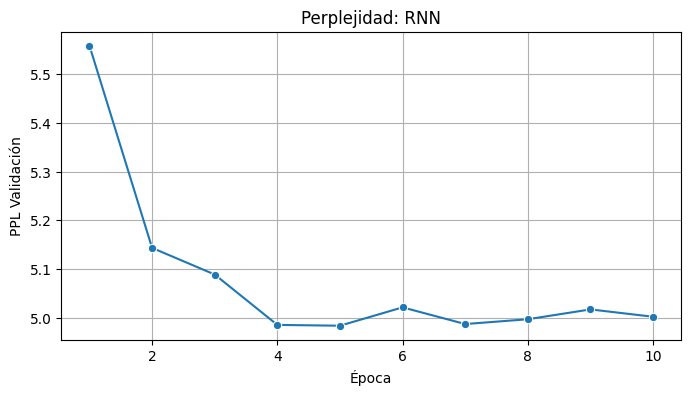

In [45]:
# Preparar datos (solo se hace una vez)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val, max_context_size, vocab_size)






==================== Entrenando/Cargando RNN_con_dropout ====================
🚀 Iniciando entrenamiento...
Epoch 1/20 - loss: 1.8873 - val_ppl: 5.5322
  -> Nuevo mejor modelo guardado!
Epoch 2/20 - loss: 1.5643 - val_ppl: 5.0824
  -> Nuevo mejor modelo guardado!
Epoch 3/20 - loss: 1.4757 - val_ppl: 4.9441
  -> Nuevo mejor modelo guardado!
Epoch 4/20 - loss: 1.4320 - val_ppl: 4.9185
  -> Nuevo mejor modelo guardado!
Epoch 5/20 - loss: 1.4067 - val_ppl: 4.8915
  -> Nuevo mejor modelo guardado!
Epoch 6/20 - loss: 1.3907 - val_ppl: 4.8923
Epoch 7/20 - loss: 1.3800 - val_ppl: 4.9727
Epoch 8/20 - loss: 1.3728 - val_ppl: 4.9432
Epoch 9/20 - loss: 1.3674 - val_ppl: 4.9509
Epoch 10/20 - loss: 1.3636 - val_ppl: 4.9395
🛑 Early stopping activado


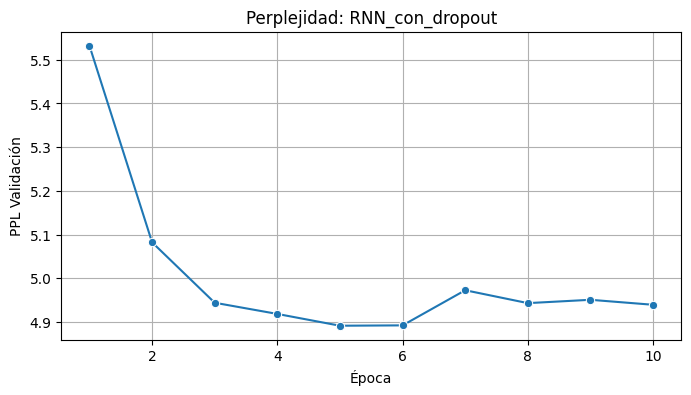

In [48]:
# 2. Entrenar RNN con dropout
rnn_model, rnn_hist = train_and_evaluate(RNNModel, "RNN_con_dropout", train_loader, val_inputs, val_targets, vocab_size, device)


==================== Entrenando/Cargando LSTM_con_dropout ====================
🚀 Iniciando entrenamiento...
Epoch 1/20 - loss: 1.7664 - val_ppl: 4.6991
  -> Nuevo mejor modelo guardado!
Epoch 2/20 - loss: 1.2971 - val_ppl: 4.5867
  -> Nuevo mejor modelo guardado!
Epoch 3/20 - loss: 1.1664 - val_ppl: 4.9686
Epoch 4/20 - loss: 1.1016 - val_ppl: 5.1795
Epoch 5/20 - loss: 1.0667 - val_ppl: 5.4434
Epoch 6/20 - loss: 1.0453 - val_ppl: 5.4113
Epoch 7/20 - loss: 1.0307 - val_ppl: 5.6836
🛑 Early stopping activado


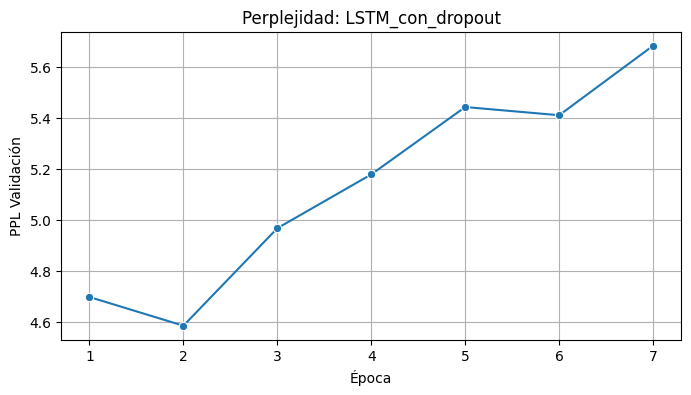

In [49]:
# 2. Entrenar LSTM con dropout
lstm_model, lstm_hist = train_and_evaluate(LSTMModel, "LSTM_con_dropout", train_loader, val_inputs, val_targets, vocab_size, device)




==================== Entrenando/Cargando GRU_con_dropout ====================
🚀 Iniciando entrenamiento...
Epoch 1/20 - loss: 1.6770 - val_ppl: 4.4822
  -> Nuevo mejor modelo guardado!
Epoch 2/20 - loss: 1.2678 - val_ppl: 4.4830
Epoch 3/20 - loss: 1.1752 - val_ppl: 4.6711
Epoch 4/20 - loss: 1.1354 - val_ppl: 4.7837
Epoch 5/20 - loss: 1.1156 - val_ppl: 4.8646
Epoch 6/20 - loss: 1.1035 - val_ppl: 4.8566
🛑 Early stopping activado


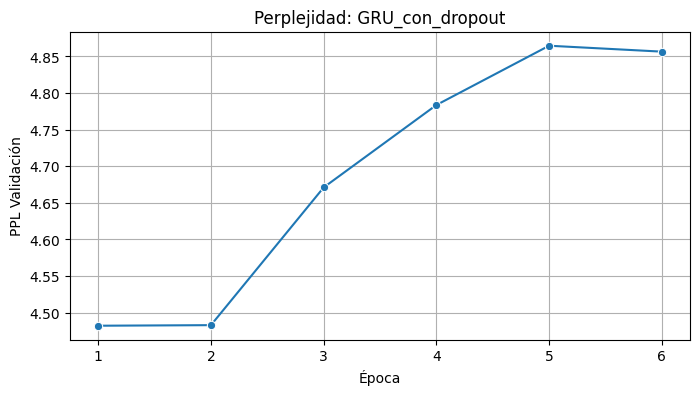

In [50]:
# 3. Entrenar GRU con dropout
gru_model, gru_hist = train_and_evaluate(GRUModel, "GRU_con_dropout", train_loader, val_inputs, val_targets, vocab_size, device)

## Conclusiones del resultado de los entrenamientos de los modelos.

Para entrenar estos modelos se puso una paciencia de 5 epochs, es decir, que si el modelo no mejora en 5 epochs, se detiene el entrenamiento. Ademas, se definió un dropout de 0.1 para evitar el sobreajuste, esto permitió obtener mejores resultados en las métricas. 

El modelo de RNN tuvo un aprendizaje mas lento y requirió mas epochs para lograr los mejores resultados. 

Los modelos de LSTM y GRU tuvieron un aprendizaje mas rapido y con menos epochs lograron mejores resultados. Sin embargo, los modelos enseguida se ve que sobre ajustaban y al cabo de pocas epochs se detuvieron (early stopping activado).




## Probando distintos modelos y distintas temperaturas

In [51]:
input_text = "isla desierta"
# Lista de modelos a probar
modelos = [
    ("RNN", rnn_model),
    ("LSTM", lstm_model),
    ("GRU", gru_model)
]


temperaturas = [0.1, 1.0, 2.0] # Baja, Normal, Alta

for nombre, modelo in modelos:
    print(f"\n{'='*40}")
    print(f"🤖 Modelo: {nombre}")
    print(f"{'='*40}")
    
    for t in temperaturas:
        print(f"\n  🌡️ Temperatura: {t}")
        # Generamos
        salidas = beam_search(modelo, num_beams=5, num_words=100, input_text=input_text, max_length=max_context_size, temp=t, mode="sto")
        # Mostramos la mejor opción
        print(f"  📝 Texto: {decode(salidas[0])}")


🤖 Modelo: RNN

  🌡️ Temperatura: 0.1
  📝 Texto: isla desierta a casa con la esperanza de que no había contraría con la esperanza de que no había contraría con la

  🌡️ Temperatura: 1.0
  📝 Texto: isla desiertamente que era un torta de las
pusiese estaba seguro de la costa de que habían medio de la costa de q

  🌡️ Temperatura: 2.0
  📝 Texto: isla desiertadamente. no dondí amadoz de eran llevara la cabrioles. donde esperaajas, y luego nos haciendo la mas

🤖 Modelo: LSTM

  🌡️ Temperatura: 0.1
  📝 Texto: isla desiertas y después de la costa de mis palabras necesitaba en otras cosas que había traído a casa con una ca

  🌡️ Temperatura: 1.0
  📝 Texto: isla desiertas y dos de los que no estaba salidadoras de sus criaturas, como el que nos encontraba el barco en el

  🌡️ Temperatura: 2.0
  📝 Texto: isla desiertar en la sobre fiallencir, que predesión de pensar on sis recortes de pala
rota. temían bala
más de e

🤖 Modelo: GRU

  🌡️ Temperatura: 0.1
  📝 Texto: isla desierta, como si fuese un 

## Conclusiones a cerca de la influencia en los valores de temperatura


Talvez es algo obvio, pero considerando que el modelo trabaja con caracteres, al menos la mayoría de las predicciones son palabras. Es decir, no hay predicciones del tipo "gtyer" o "uilña" u otro tipo de acumulacion de caracteres que no formen una palabra.

Los modelos LSTM y GRU desde mi punto de vista, tienen mejores resultados de textos.

Tal como era de esperarse, para un aumento de la temperatura, se observan resultados un poco mas raros.